In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip -q /content/gdrive/MyDrive/cropped.zip

In [3]:
import os
os.makedirs('checkpoints', exist_ok=True)

In [4]:
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from tqdm.notebook import tqdm


Модель

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.skip = nn.Identity() if in_channels == out_channels else nn.Conv2d(in_channels, out_channels, 1)

        self.conv1 = nn.Conv2d(in_channels, out_channels // 2, 1)
        self.bn1 = nn.BatchNorm2d(out_channels // 2)
        self.conv2 = nn.Conv2d(out_channels // 2, out_channels // 2, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels // 2)
        self.conv3 = nn.Conv2d(out_channels // 2, out_channels, 1)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        residual = self.skip(x)
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.relu(self.bn2(self.conv2(x)))
        x = self.bn3(self.conv3(x))
        return self.relu(x + residual)


class HourglassBlock(nn.Module):
    def __init__(self, block_count, in_channels):
        super().__init__()
        self.is_inner = (block_count == 0)

        if self.is_inner:
            self.inner = nn.Sequential(
                ResidualBlock(in_channels, in_channels),
                ResidualBlock(in_channels, in_channels),
                ResidualBlock(in_channels, in_channels))
        else:
            self.down_sampling = nn.Sequential(
                nn.MaxPool2d(2),
                ResidualBlock(in_channels, in_channels))

            self.up_sampling = nn.Sequential(
                nn.Upsample(scale_factor=2, mode='bilinear'),
                ResidualBlock(in_channels, in_channels))

            self.trans = ResidualBlock(in_channels, in_channels)
            self.sub_hourglass = HourglassBlock(block_count - 1, in_channels)

    def forward(self, inputs):
        if self.is_inner:
            return self.inner(inputs)
        else:
            down_sampled = self.down_sampling(inputs)
            transed = self.trans(down_sampled)
            sub_net_output = self.sub_hourglass(down_sampled)
            return self.up_sampling(transed + sub_net_output)


class HourglassNet(nn.Module):
    def __init__(self, stack_count, block_count, in_channels, out_channels):
        super().__init__()
        self.stack_count = stack_count

        self.pre_process = nn.Sequential(
            nn.Conv2d(3, in_channels, 3, padding=1),
            ResidualBlock(in_channels, in_channels),
            nn.MaxPool2d(2),
            ResidualBlock(in_channels, in_channels),
            nn.MaxPool2d(2),
            ResidualBlock(in_channels, in_channels))

        self.hourglass = nn.ModuleList([
            HourglassBlock(block_count, in_channels) for _ in range(stack_count)
        ])

        self.features = nn.ModuleList([
            ResidualBlock(in_channels, in_channels) for _ in range(stack_count)
        ])

        self.intermediate_supervision = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, 1) for _ in range(stack_count)
        ])

        self.feature_blocks = nn.ModuleList([
            ResidualBlock(in_channels, in_channels) for _ in range(stack_count - 1)
        ])

        self.intermediate_blocks = nn.ModuleList([
            ResidualBlock(out_channels, in_channels) for _ in range(stack_count - 1)
        ])

    def forward(self, inputs):
        outputs = []
        x = self.pre_process(inputs)
        for i in range(self.stack_count):
            y = self.hourglass[i](x)
            y = self.features[i](y)
            out = self.intermediate_supervision[i](y)
            outputs.append(out)
            if i < self.stack_count - 1:
                y = self.feature_blocks[i](y)
                z = self.intermediate_blocks[i](out)
                x = x + y + z
        return outputs


def create_hourglass_net():
    return HourglassNet(
        stack_count = 2,
        block_count = 4,
        in_channels = 256,
        out_channels = 5,
    )


In [6]:
model = create_hourglass_net()

In [7]:
sum([len(p.ravel()) for p in model.parameters()])

7916682

Датасет

In [8]:
def create_heatmap(size, landmark, sigma=2):
    """
    Создаёт один heatmap с гауссовым ядром вокруг точки.

    :param size: (height, width) — размер heatmap'а
    :param landmark:(x, y) — координаты точки
    :param sigma
    :return: heatmap массив
    """
    x, y = landmark
    h, w = size

    # Обрезаем координаты, чтобы не выйти за пределы изображения
    x = min(max(0, int(x)), w - 1)
    y = min(max(0, int(y)), h - 1)

    xx, yy = np.meshgrid(np.arange(w), np.arange(h))
    heatmap = np.exp(-((yy - y)**2 + (xx - x)**2) / (2 * sigma**2))
    return heatmap


def landmarks_to_heatmaps(image_shape, landmarks, sigma=2):
    """
    Преобразует список из N точек в набор из N heatmap'ов.

    :param image_shape: исходный размер изображения (H, W)
    :param landmarks: список из N пар координат [(x1, y1), (x2, y2), ..., (xN, yN),]
    :param sigma:
    :return: массив heatmap'ов вида [N, H, W]
    """
    heatmaps = []

    for (x, y) in landmarks:
        hm = create_heatmap(image_shape, (x, y), sigma=sigma)
        heatmaps.append(hm)

    return np.array(heatmaps)


def heatmaps_to_points(heatmaps):
    n, c, h, w = heatmaps.shape
    index = heatmaps.view(n, c, 1, -1).argmax(dim=-1)
    points = torch.cat([index % w, index // w], dim=2)
    return points


In [9]:
train_df = pd.read_csv('cropped/train_landmarks.csv', index_col=0)
train_df

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000009.jpg,198,205,338,201,294,297,190,337,334,333
000010.jpg,90,118,172,107,140,162,108,199,183,186
000014.jpg,127,143,220,151,173,213,125,230,198,241
000153.jpg,90,103,159,100,128,147,93,170,166,168
000185.jpg,71,110,140,88,97,131,92,187,147,169
...,...,...,...,...,...,...,...,...,...,...
202489.jpg,143,107,187,110,177,158,115,166,166,176
202499.jpg,76,82,135,84,102,128,71,141,144,139
202531.jpg,58,59,97,53,93,85,70,104,97,97
202535.jpg,95,116,169,111,133,167,103,191,179,185


In [10]:
val_df = pd.read_csv('cropped/val_landmarks.csv', index_col=0)
val_df

,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
000085.jpg,246,365,478,329,374,509,310,589,514,561
000156.jpg,114,142,212,141,149,203,120,241,218,238
000174.jpg,122,143,222,148,165,213,117,243,224,246
000256.jpg,107,96,165,98,152,134,111,158,162,160
000330.jpg,42,64,84,54,68,90,53,107,91,99
...,...,...,...,...,...,...,...,...,...,...
202306.jpg,56,63,104,74,64,92,48,107,91,118
202311.jpg,107,122,192,133,143,185,107,211,178,220
202373.jpg,62,48,87,47,90,66,71,90,91,88
202525.jpg,116,123,193,129,153,176,117,213,176,212


In [11]:
class FaceDataset(Dataset):
    def __init__(self, path, dataframe, transform):
        self.path = path
        self.data = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, item):
        img_name = self.data.index[item]
        img_path = f'{self.path}{img_name}'

        img = Image.open(img_path)
        img = np.asarray(img)

        landmarks = self.data.iloc[item]
        landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

        transformed = self.transform(image=img, keypoints=landmarks)
        image, keypoints = transformed["image"], transformed["keypoints"]

        target = torch.tensor(landmarks_to_heatmaps((64, 64), keypoints / 4), dtype=torch.float32)

        return image, target


In [12]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.Resize(256, 256),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format="xy"),
)

val_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    keypoint_params=A.KeypointParams(format="xy"),
)

In [13]:
train_dataset = FaceDataset('cropped/train/', train_df, train_transform)
val_dataset = FaceDataset('cropped/val/', val_df, val_transform)

In [14]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

Обучение модели

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [16]:
model.load_state_dict(torch.load('checkpoints/epoch_50.pth'))
model = model.to(device)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=5)
criterion = nn.MSELoss()

In [18]:
epochs = 20

In [19]:
def train(start=0):
    train_losses = []
    val_losses = []
    lr_list = []

    best_val_loss = float('inf')

    epoch_tqdm = tqdm(range(start, start + epochs), leave=True)
    for epoch in epoch_tqdm:
        model.train()
        train_losses_per_epoch = []

        train_tqdm = tqdm(train_loader, leave=True)
        for batch_x, batch_y in train_tqdm:
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            outputs = model(batch_x)
            loss = sum(criterion(output, batch_y) for output in outputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses_per_epoch.append(loss.item())
            train_tqdm.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss={loss.item():.4f}")

        train_loss = np.mean(train_losses_per_epoch)
        train_losses.append(train_loss)

        train_tqdm.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss={train_loss:.4f}")

        model.eval()
        val_losses_per_epoch = []

        with torch.no_grad():
            val_tqdm = tqdm(val_loader, leave=True)
            for batch_x, batch_y in val_tqdm:
                batch_x = batch_x.to(device)
                batch_y = batch_y.to(device)

                outputs = model(batch_x)
                loss = sum(criterion(output, batch_y) for output in outputs)

                val_losses_per_epoch.append(loss.item())
                val_tqdm.set_description(f"Epoch [{epoch+1}/{epochs}], val_loss={loss.item():.4f}")

        val_loss = np.mean(val_losses_per_epoch)
        val_losses.append(val_loss)

        val_tqdm.set_description(f"Epoch [{epoch+1}/{epochs}], val_loss={val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f'checkpoints/epoch_{epoch+1}_best_val_loss.pth')

        scheduler.step(val_loss)
        lr = scheduler.get_last_lr()
        lr_list.append(lr)

        epoch_tqdm.set_description(f"Epoch [{epoch+1}/{epochs}], train_loss_mean={train_losses[-1]:.4f}, val_loss_mean={val_losses[-1]:.4f}, lr={lr}")

    return train_losses, val_losses, lr_list


In [20]:
train_losses, val_losses, lr_list = train(start=50)
train_losses, val_losses, lr_list

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

  0%|          | 0/320 [00:00<?, ?it/s]

  0%|          | 0/128 [00:00<?, ?it/s]

([np.float64(0.009464298114471604),
  np.float64(0.008723982209630776),
  np.float64(0.008500496088527144),
  np.float64(0.008191072419867851),
  np.float64(0.007945320985163562),
  np.float64(0.008086775263655),
  np.float64(0.007938585044757928),
  np.float64(0.00785434783610981),
  np.float64(0.007794489586376585),
  np.float64(0.007676045873085968),
  np.float64(0.007767821424931753),
  np.float64(0.007587487561977468),
  np.float64(0.007509108143858611),
  np.float64(0.0074232352897524835),
  np.float64(0.007551811877056025),
  np.float64(0.007404352638695854),
  np.float64(0.007379182992735878),
  np.float64(0.0073982539921416905),
  np.float64(0.007474557042587549),
  np.float64(0.007410142426670064)],
 [np.float64(0.01379687443113653),
  np.float64(0.012986066340090474),
  np.float64(0.009942435339326039),
  np.float64(0.010635133414325537),
  np.float64(0.009078039733140031),
  np.float64(0.01103219915603404),
  np.float64(0.01138848963091732),
  np.float64(0.00956451661841129

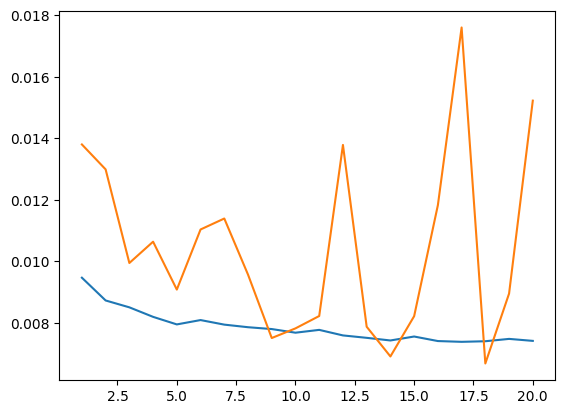

In [21]:
plt.plot(range(1, len(train_losses) + 1), train_losses)
plt.plot(range(1, len(val_losses) + 1), val_losses)


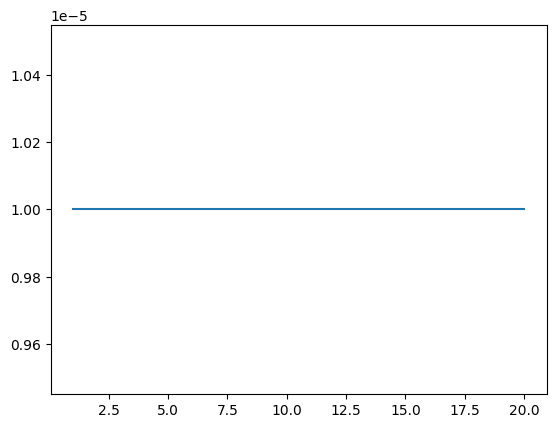

In [22]:
plt.plot(range(1, len(lr_list) + 1), lr_list)

In [23]:
torch.save(model.state_dict(), f'checkpoints/hourglass.pth')

Смотрим пару произвольных картинок

In [33]:
def show_landmarks(image, landmarks):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='.', c='r')
    plt.show()

def show_outputs(outputs):
    n, m = len(outputs), outputs[0].shape[1]

    plt.figure(figsize=(15, 6))
    for i, out in enumerate(outputs):
        for j in range(m):
            plt.subplot(n, m, i * m + j + 1)
            heatmap = out[0, j].cpu()
            plt.imshow(heatmap)

    plt.show()

def show_points(image, landmarks, points):
    plt.imshow(image)
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=20, marker='.', c='r')
    plt.scatter(points[:, :, 0], points[:, :, 1], s=20, marker='+', c='b')
    plt.show()

def predict_points(image, landmarks):
    show_landmarks(image, landmarks)

    h, w = image.shape[:2]

    transformed = val_transform(image=image)
    transformed_image = transformed["image"]

    with torch.no_grad():
        outputs = model(transformed_image.unsqueeze(0).to(device))

    show_outputs(outputs)

    scale = h / 64
    points = heatmaps_to_points(outputs[-1].cpu()) * scale

    show_points(image, landmarks, points)

    print(landmarks)
    print(points)


022133.jpg


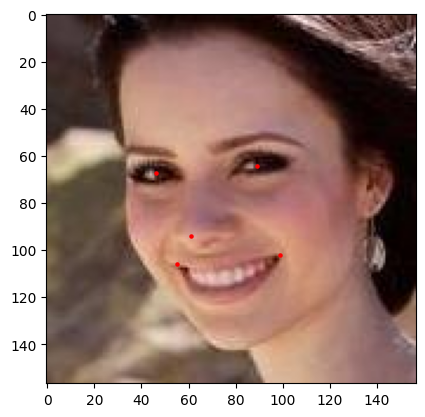

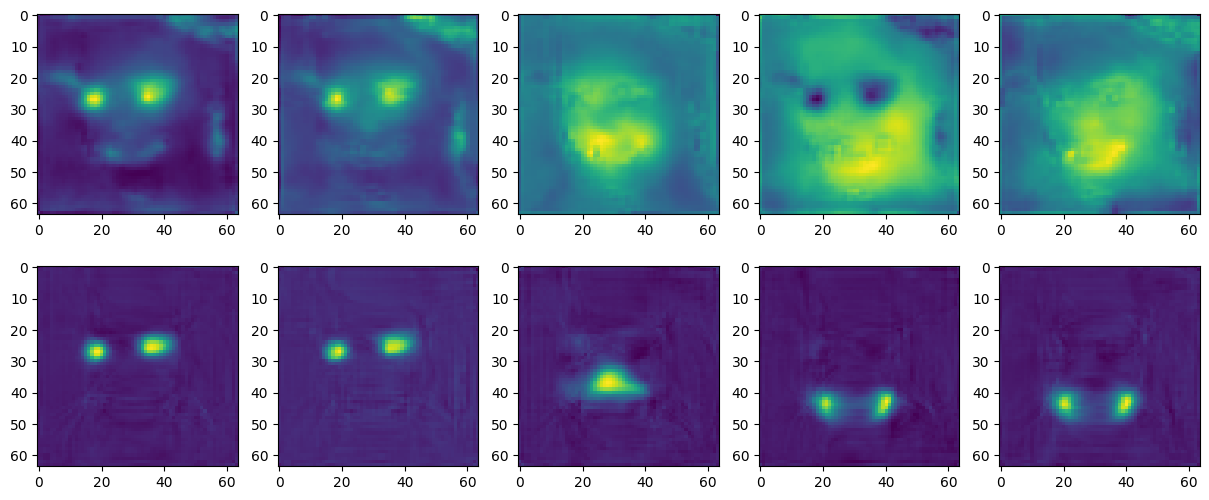

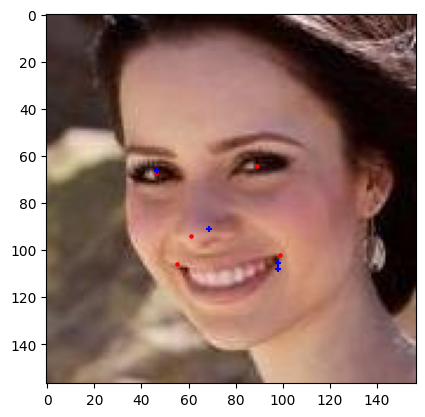

[[ 46.  67.]
 [ 89.  64.]
 [ 61.  94.]
 [ 55. 106.]
 [ 99. 102.]]
tensor([[[ 46.6094,  66.2344],
         [ 46.6094,  66.2344],
         [ 68.6875,  90.7656],
         [ 98.1250, 105.4844],
         [ 98.1250, 107.9375]]])


In [34]:
n = random.randint(0, len(val_df)-1)

img_name = val_df.index[n]
img_path = f'cropped/val/{img_name}'

print(img_name)

img = Image.open(img_path)
img = np.asarray(img)

landmarks = val_df.iloc[n]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

predict_points(img, landmarks)


161866.jpg


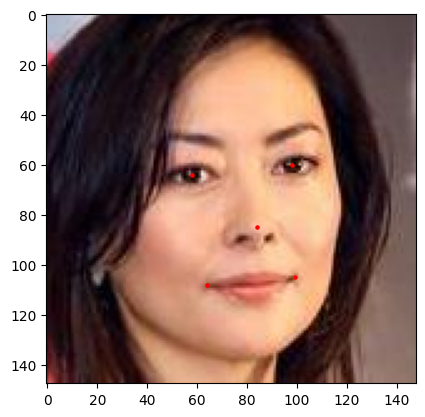

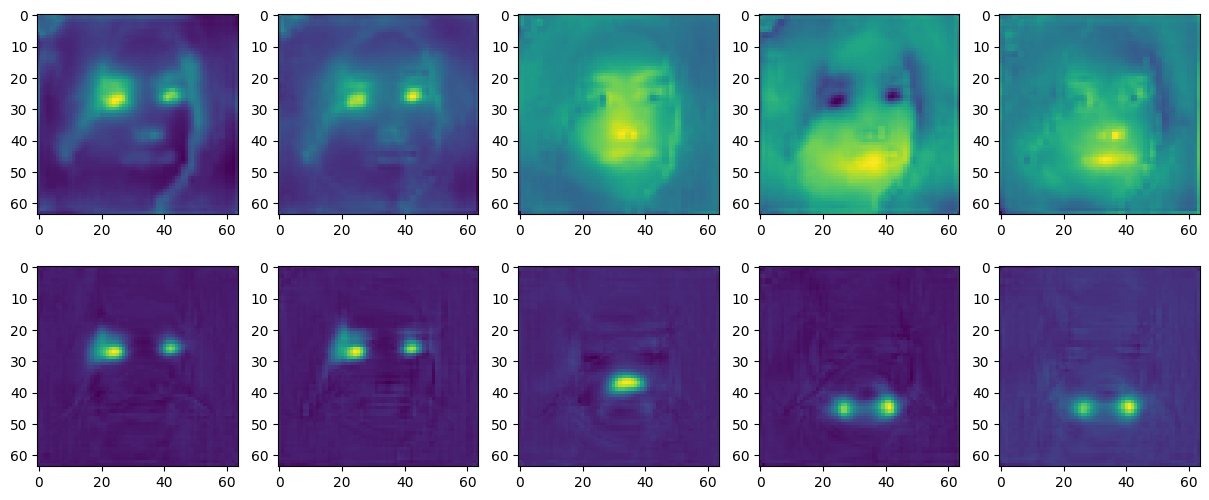

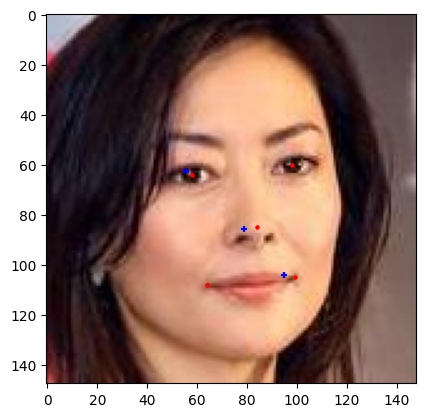

[[ 58.  64.]
 [ 98.  60.]
 [ 84.  85.]
 [ 64. 108.]
 [ 99. 105.]]
tensor([[[ 55.5000,  62.4375],
         [ 55.5000,  62.4375],
         [ 78.6250,  85.5625],
         [ 94.8125, 104.0625],
         [ 94.8125, 104.0625]]])


In [35]:
n = random.randint(0, len(val_df)-1)

img_name = val_df.index[n]
img_path = f'cropped/val/{img_name}'

print(img_name)

img = Image.open(img_path)
img = np.asarray(img)

landmarks = val_df.iloc[n]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

predict_points(img, landmarks)


Что-то оно и переобучилось и не разделяет правые и левые точки